#04. PyTorch Custom Datasets Notebook

In [1]:
##0. Importing pytorch and setting up device agnostic code 
import torch 
from torch import nn

#Note: PyTorch 1.10..0 + for this
torch.__version__

'2.1.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import requests
import zipfile
from pathlib import Path

#Setup path to a data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one... ")
    image_path.mkdir(parents=True, exist_ok=True)

#Download pizza, steak and sushi data 
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data")
    f.write(request.content)

#Unzip pizza, steak, sushi data 
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak & sushi data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak & sushi data...


In [4]:
data_path / "pizza_steak_sushi.zip"

WindowsPath('data/pizza_steak_sushi.zip')

In [5]:
### 2. Becoming one with data (data preparation & exploration)


In [6]:
import os 
def walk_through_dir(dir_path):
    """ walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [8]:
#Setup train & test path 
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing an image 

data\pizza_steak_sushi\train\sushi\843815.jpg
sushi
Random image path: data\pizza_steak_sushi\train\sushi\843815.jpg
Image class: sushi
Image height : 512
Image width : 512


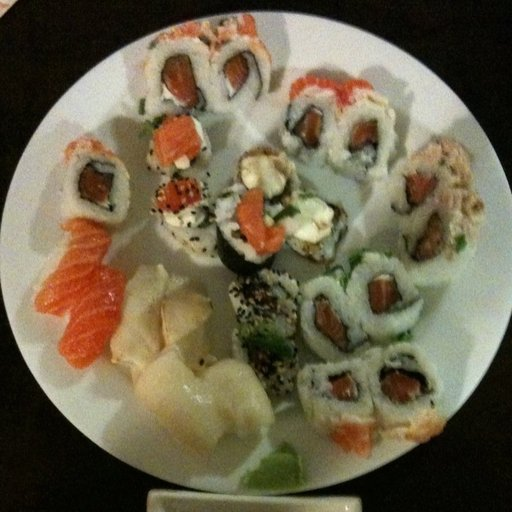

In [9]:
import random 
from PIL import Image 

#Set seed 
#random.seed(42)

#1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path 
random_image_path = random.choice(image_path_list)

print(random_image_path)

#3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

#4. Open image 
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

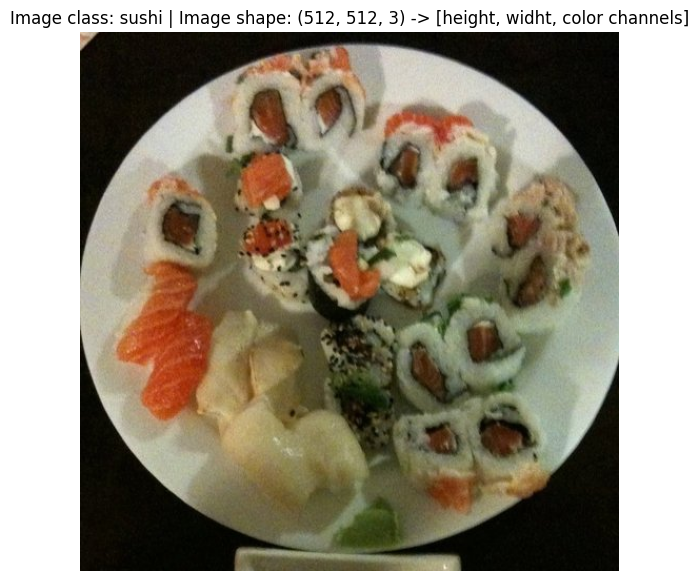

In [10]:
import numpy as np 
import matplotlib.pyplot as plt

#Turn image into array 
img_as_array = np.asarray(img)

#Plot the image with matplotlit
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, widht, color channels]")
plt.axis(False)

## 3. Transforming data

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

C:\Users\parim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###3.1 Transforming data with torchvision.transforms 

In [12]:
#Write a transform for image 

data_transform = transforms.Compose([
    #Resize our images to 64*64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor 
    transforms.ToTensor()
])

In [13]:
data_transform(img).dtype

torch.float32

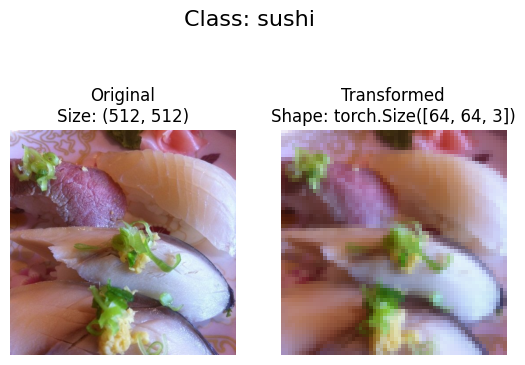

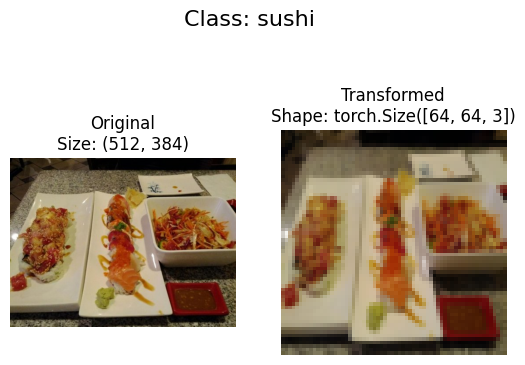

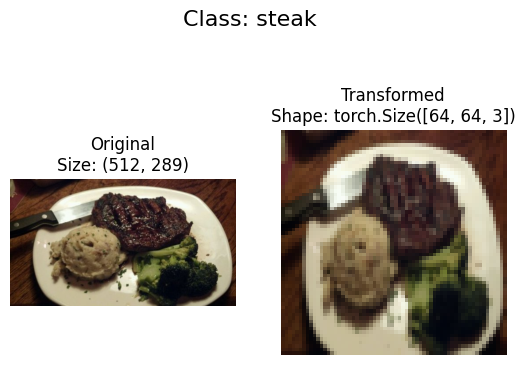

In [14]:
def plot_transformed_images(image_paths:list, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/transforms them then plots the original vs transformed version. 
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            #Transform & plot target image 
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

###4. Option 1: Loading image data using ImageFolder

In [17]:
#Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a tranform for the data 
                                  target_transform=None) #tansform for the label 

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
#Get class names as dict 
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
#Check the lengths of dataset 
len(train_data), len(test_data)

(225, 75)

In [23]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [31]:
#Index on the train_data Dataset to get a single image and label 
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor\n {img}")
print(f"Image shape: {img.shape}")
print(f" Image datatype: {img.dtype} ")
print(f" Image label: {label}")
print(f" Label datatype: {type(label)}")

Image tensor
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

 Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
 Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

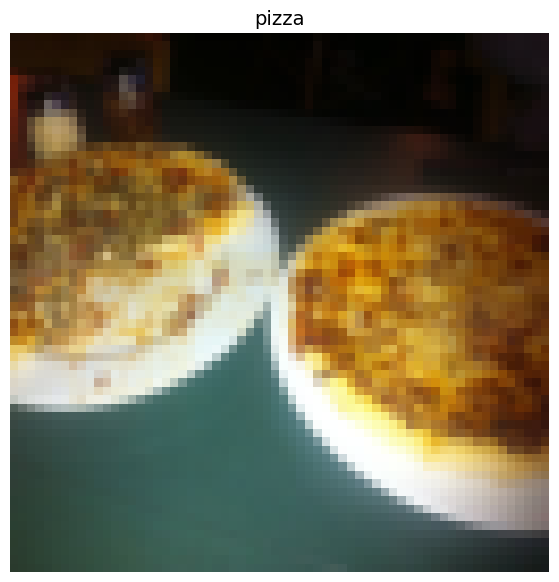

In [32]:
#Rearrange the order of dimensions 
img_permute = img.permute(1, 2, 0)

#print out different shapes 
print(f" Original shape: {img.shape} -> [color_channels, height, width]")
print(f" Image permute: {img_permute.shape} -> [height, width, color_channels]")

#plot the image 
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)


### 4.1 Turn loaded images into "DataLoader" 

In [33]:
import os 
os.cpu_count()

8

In [44]:
#Trun train & test datasets into DataLoader'set
from torch.utils.data import DataLoader 
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, 
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2eb40faa9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x2eb39ddeb90>)

In [45]:
img, label = next(iter(train_dataloader))

#Batch size will now be 1, you can change the batchsize 
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f" Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
 Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom 'Dataset'

In [48]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [50]:
#Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 creating a helper function to get class name

In [54]:
#Setup the path for target directory 
target_directory = train_dir
print(f"Target dir:{target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir:data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [55]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [58]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """ Finds the class folder names in a target directory. """
    #1. Get the class names by scanning the target directory 
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

    #2. Raise an error if classname not found 
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure.")
    
    #3. Create a dictionary of index labels (computers prefer numbers)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [59]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom 'Dataset' to replicate 'ImageFolder'

In [67]:
#0. Write a custom dataset class 
from torch.utils.data import Dataset

#1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    #2. Initialize custom dataset
    def __init__(self, 
                 targ_dir: str, 
                 transform=None):
        #3. Create class attributes
        #Get all the image paths 
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        #Setup transforms
        self.transform =transform

        #Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    #4. Create a funcion to load images
    def load_image(self, index: int) -> Image.Image:
        """ Opens an image via a path & returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    #5. Overwrite __len__()
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)
    
    #6. Overwrite __getitem__() method to return a particular sample 
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """ Returns one sample of data, data and label (X, y)."""
        img = self.load_image(index)
        class_names = self.paths[index].parent.name #expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_names]

        #Transform if necessary 
        if self.transform:
            return self.transform(img), class_idx #return data, label (X, y)
        else: 
            return img, class_idx #return untransformed image & label 

In [62]:
img, label = train_data[0]

In [63]:
img, label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [69]:
#Create a transform 
train_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()
])